In [48]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, col, broadcast, avg, coalesce, lit, count
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType
import pandas as pd
import matplotlib.pyplot as plt
import time
import json

# Initialize SparkSession only once
spark = SparkSession.builder \
    .appName("lvb-spark") \
    .config('spark.master', 'local') \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.0') \
    .getOrCreate()

# Optimize shuffle partitions based on your machine's cores
spark.conf.set("spark.sql.shuffle.partitions", "8")  # Adjust as needed

In [49]:
start_time = time.time()

# Read enriched departures from Parquet file
df = spark.read.parquet("data/enriched_01.parquet")
print(f"Loaded Parquet data in {time.time() - start_time:.2f} seconds")

# Load stops data
start_time = time.time()
stops_df = spark.read.option("multiLine", "true").json("data/stops.json") \
    .select(explode("stops").alias("stop")) \
    .select(col("stop.id").alias("id"), col("stop.name").alias("name"))
print(f"Loaded stops data in {time.time() - start_time:.2f} seconds")

Loaded Parquet data in 0.88 seconds
Loaded stops data in 0.70 seconds


24/09/23 12:19:47 WARN CacheManager: Asked to cache already cached data.


+------+-----+
|stopId|count|
+------+-----+
|956291|79129|
|955251|64613|
|957859|62146|
|953847|38248|
|955252|37669|
|955102|36057|
|957394|32751|
|955500|32653|
|956502|31929|
|958308|30845|
|954125|30453|
|956558|30069|
|957875|29689|
|956519|29547|
|955501|28849|
+------+-----+

Calculated top 15 stop usage in 0.61 seconds


24/09/23 12:19:48 WARN CacheManager: Asked to cache already cached data.


+------+-------------------------------------------+-----+
|stopId|name                                       |count|
+------+-------------------------------------------+-----+
|956291|Hauptbahnhof (Tram/Bus), Leipzig           |79129|
|955251|Augustusplatz, Leipzig                     |64613|
|957859|Goerdelerring, Leipzig                     |62146|
|953847|Waldplatz, Leipzig                         |38248|
|955252|Wilhelm-Leuschner-Platz (Tram/Bus), Leipzig|37669|
|955102|Angerbrücke/Straßenbahnhof, Leipzig        |36057|
|957394|Adler, Leipzig                             |32751|
|955500|Leibnizstr., Leipzig                       |32653|
|956502|Reudnitz Koehlerstr., Leipzig              |31929|
|958308|Connewitzer Kreuz, Leipzig                 |30845|
|954125|Hermann-Liebmann-/Eisenbahnstr., Leipzig   |30453|
|956558|Wilhelm-Liebknecht-Platz, Leipzig          |30069|
|957875|Friedrich-List-Platz, Leipzig              |29689|
|956519|Sportforum Süd, Leipzig                    |2954

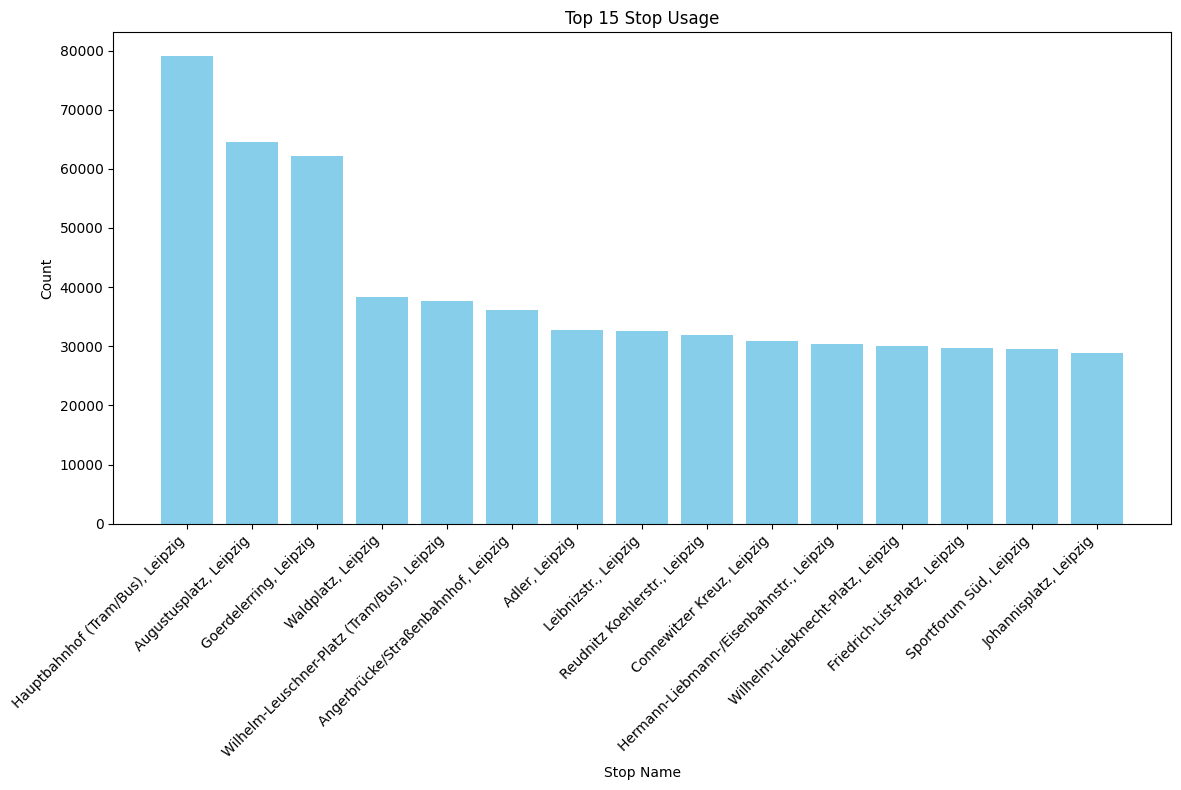

In [50]:
start_time = time.time()

# Calculate top 15 stop usage
top_stop_usage = df.groupBy('stopId') \
    .count() \
    .orderBy(col('count').desc()) \
    .limit(15) \
    .cache()

top_stop_usage.show()
print(f"Calculated top 15 stop usage in {time.time() - start_time:.2f} seconds")

# Join with stop names using broadcast join
start_time = time.time()
top_stops_with_names = top_stop_usage.join(
    broadcast(stops_df),
    top_stop_usage.stopId == stops_df.id,
    "inner"
).select(
    top_stop_usage.stopId,
    "name",
    "count"
).orderBy(col("count").desc()) \
 .cache()

top_stops_with_names.show(truncate=False)
print(f"Joined top 15 stop usage with names in {time.time() - start_time:.2f} seconds")

# Convert to Pandas for plotting
start_time = time.time()
stop_usage_pd = top_stops_with_names.toPandas()
print(f"Converted top 15 to Pandas in {time.time() - start_time:.2f} seconds")

# Plotting
plt.figure(figsize=(12, 8))
plt.bar(stop_usage_pd['name'], stop_usage_pd['count'], color='skyblue')
plt.title('Top 15 Stop Usage')
plt.xlabel('Stop Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

24/09/23 12:19:49 WARN CacheManager: Asked to cache already cached data.
24/09/23 12:19:49 WARN CacheManager: Asked to cache already cached data.


+-------+-------------------------------------+------------------+
|stopId |name                                 |avg_delay         |
+-------+-------------------------------------+------------------+
|8012309|Markkleeberg Mitte                   |482.4             |
|8011683|Gräfenhainichen                      |436.0427807486631 |
|8010222|Lutherstadt Wittenberg Hbf           |306.50943396226415|
|8012409|Muldenstein                          |301.984126984127  |
|8011296|Burgkemnitz                          |279.62566844919786|
|8010281|Pratau                               |264.6112600536193 |
|958189 |Rückmarsdorf Löwen Center, Leipzig   |253.006993006993  |
|957869 |Rückmarsdorf Großer Marktweg, Leipzig|252.5874125874126 |
|8011150|Bergwitz                             |248.7433155080214 |
|8013371|Zahna                                |238.55421686746988|
|8011961|Jeßnitz(Anh)                         |233.1772575250836 |
|8011699|Greppin                              |232.58225324027

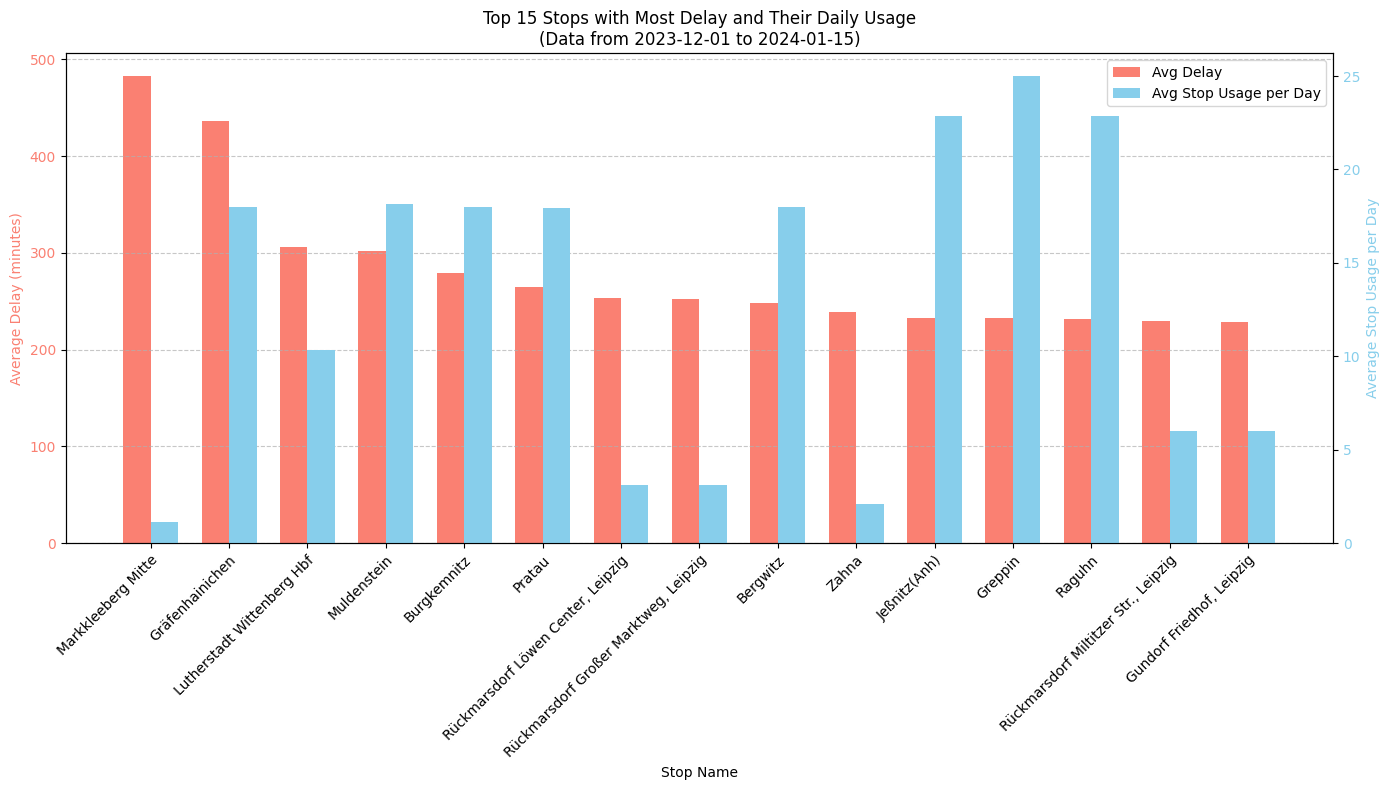

In [51]:
start_time = time.time()

# Calculate top 15 stops with the most delay
start_time = time.time()

top_delay_stops = df.groupBy('stopId') \
    .agg(avg('delay').alias('avg_delay')) \
    .orderBy(col('avg_delay').desc()) \
    .limit(15) \
    .cache()

top_delay_stops_with_names = top_delay_stops.join(
    broadcast(stops_df),
    top_delay_stops.stopId == stops_df.id,
    "inner"
).select(
    top_delay_stops.stopId,
    "name",
    "avg_delay"
).orderBy(col("avg_delay").desc()) \
 .cache()

top_delay_stops_with_names.show(truncate=False)
print(f"Calculated top 15 stops with the most delay in {time.time() - start_time:.2f} seconds")

# Convert to Pandas for plotting
start_time = time.time()
delay_stops_pd = top_delay_stops_with_names.toPandas()
execution_duration = time.time() - start_time
print(f"Converted top 15 to Pandas in {round(execution_duration, 2)} seconds")

# Get date range
date_range = df.agg(
    F.min("plannedWhen").alias("min_date"),
    F.max("plannedWhen").alias("max_date")
).collect()[0]

min_date = date_range["min_date"]
max_date = date_range["max_date"]
days_diff = (max_date - min_date).days + 1  # Add 1 to include both start and end dates

# Get stop usage for the most delayed stops
stop_ids = delay_stops_pd['stopId'].tolist()
stop_usage = df.filter(col('stopId').isin(stop_ids)) \
    .groupBy('stopId') \
    .count() \
    .withColumn('count_per_day', col('count') / days_diff) \
    .orderBy(col('stopId'))

# Convert to Pandas and merge with delay_stops_pd
stop_usage_pd = stop_usage.toPandas()
delay_stops_pd = delay_stops_pd.merge(stop_usage_pd, on='stopId')

# Plotting
fig, ax1 = plt.subplots(figsize=(14, 8))

# Add dashed y-grid
ax1.yaxis.grid(True, linestyle='--', alpha=0.7)

# Plot average delay on the primary y-axis
bar_width = 0.35
x = range(len(delay_stops_pd['name']))
ax1.bar([i - bar_width/2 for i in x], delay_stops_pd['avg_delay'], width=bar_width, color='salmon', label='Avg Delay')
ax1.set_xlabel('Stop Name')
ax1.set_ylabel('Average Delay (seconds)', color='salmon')
ax1.tick_params(axis='y', labelcolor='salmon')
ax1.set_xticks(x)
ax1.set_xticklabels(delay_stops_pd['name'])  # Use stop names for x-axis labels


# Create a second y-axis for stop usage per day
ax2 = ax1.twinx()
ax2.bar([i + bar_width/2 for i in x], delay_stops_pd['count_per_day'], width=bar_width, color='skyblue', label='Avg Stop Usage per Day')
ax2.set_ylabel('Average Stop Usage per Day', color='skyblue')
ax2.tick_params(axis='y', labelcolor='skyblue')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title(f'Top 15 Stops with Most Delay and Their Daily Usage\n(Data from {min_date.date()} to {max_date.date()})')

# Rotate and align the tick labels so they look better
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Adjust the subplot layout
fig.tight_layout()

# Show the plot
plt.show()

24/09/23 12:35:06 WARN CacheManager: Asked to cache already cached data.
24/09/23 12:35:06 WARN CacheManager: Asked to cache already cached data.


Calculated top 15 stops with the most delay in 0.14 seconds
Joined with the original DataFrame to get lineId in 0.03 seconds
Joined with lines_df to get line names in 0.02 seconds


Converted top 15 to Pandas in 0.0 seconds


Got date range in 2.24 seconds


Got stop usage in 5.13 seconds


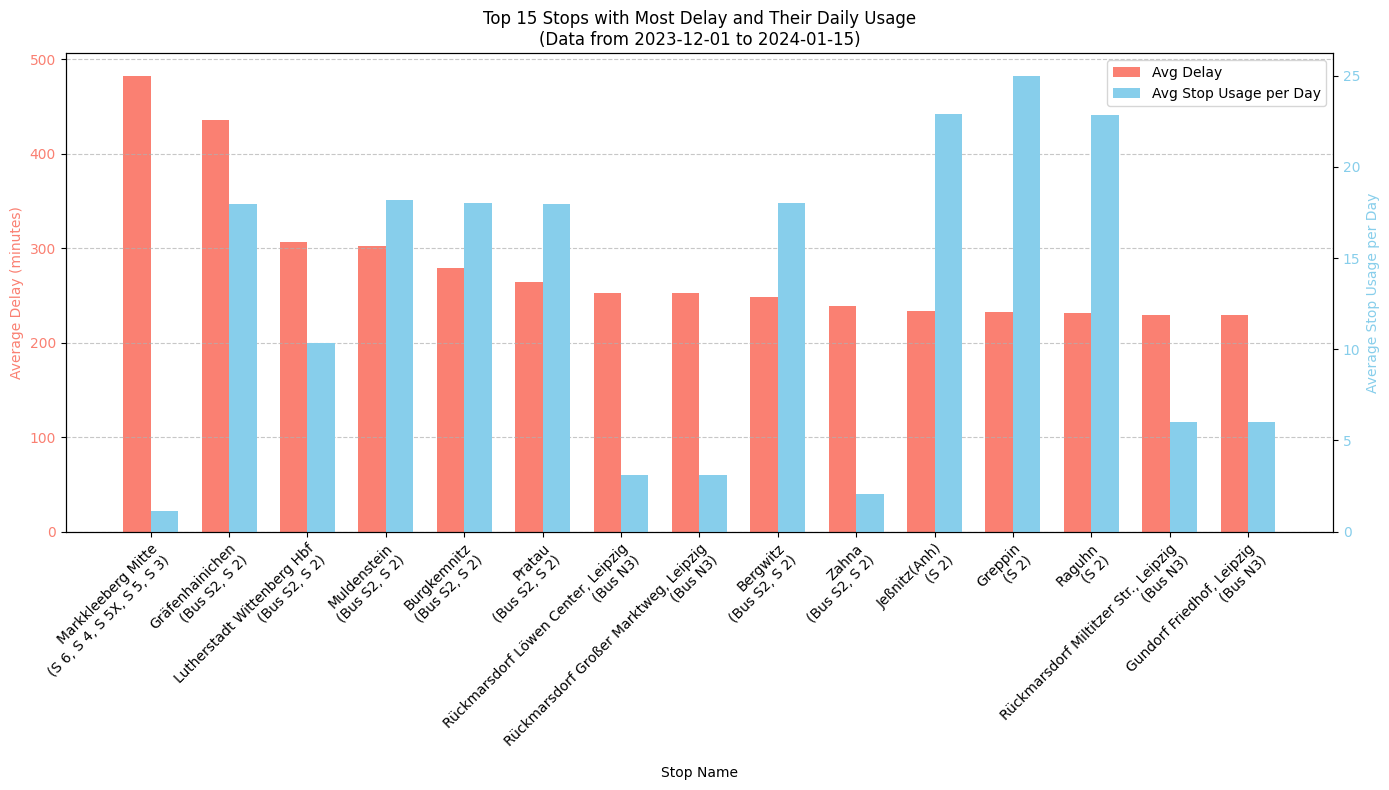

In [62]:
# Load line data
with open("data/relevantLines_with_stops.json", "r") as file:
    json_data = json.load(file)

# Create a list of rows
rows = [(line_id, line_info['name'], line_info['product']) for line_id, line_info in json_data.items()]

# Define the schema for the DataFrame
schema = StructType([
    StructField("line_id", StringType(), True),
    StructField("name", StringType(), True),
    StructField("product", StringType(), True)
])

# Create the DataFrame
lines_df = spark.createDataFrame(rows, schema)

# Calculate top 15 stops with the most delay
start_time = time.time()

top_delay_stops = df.groupBy('stopId') \
    .agg(avg('delay').alias('avg_delay')) \
    .orderBy(col('avg_delay').desc()) \
    .limit(15) \
    .cache()

top_delay_stops_with_names = top_delay_stops.join(
    broadcast(stops_df),
    top_delay_stops.stopId == stops_df.id,
    "inner"
).select(
    top_delay_stops.stopId,
    "name",
    "avg_delay"
).orderBy(col("avg_delay").desc()) \
 .cache()

print(f"Calculated top 15 stops with the most delay in {time.time() - start_time:.2f} seconds")

# Join with the original DataFrame to get lineId
start_time = time.time()
top_delay_stops_with_lineId = top_delay_stops_with_names.alias("tdswn").join(
    df.alias("df"),
    col("tdswn.stopId") == col("df.stopId"),
    "left"
).select(
    col("tdswn.stopId"),
    col("tdswn.name"),
    col("tdswn.avg_delay"),
    col("df.lineId")
).distinct()

print(f"Joined with the original DataFrame to get lineId in {time.time() - start_time:.2f} seconds")

# Join with lines_df to get line names
start_time = time.time()
stops_with_lines = top_delay_stops_with_lineId.alias("tdswl").join(
    lines_df.alias("lines"),
    col("tdswl.lineId") == col("lines.line_id"),
    "left"
).select(
    col("tdswl.stopId"),
    col("tdswl.name"),
    col("tdswl.avg_delay"),
    col("lines.name").alias("line_name")
)

print(f"Joined with lines_df to get line names in {time.time() - start_time:.2f} seconds")

# Collect the line names for each stop
stops_with_lines_pd = stops_with_lines.groupBy("stopId", "name", "avg_delay").agg(
    F.collect_list("line_name").alias("line_names")
).toPandas()

# Function to format line names
def format_line_names(line_names):
    return f"({', '.join(line_names)})" if line_names else "(No lines)"

# Apply the function to format line names
stops_with_lines_pd["line_names"] = stops_with_lines_pd["line_names"].apply(format_line_names)

# Combine stop names with line names
stops_with_lines_pd["name_with_lines"] = stops_with_lines_pd.apply(
    lambda row: f"{row['name']}\n{row['line_names']}", axis=1
)

# Convert to Pandas for plotting
start_time = time.time()
delay_stops_pd = stops_with_lines_pd
execution_duration = time.time() - start_time
print(f"Converted top 15 to Pandas in {round(execution_duration, 2)} seconds")

# Sort the DataFrame by avg_delay in descending order
delay_stops_pd = delay_stops_pd.sort_values(by='avg_delay', ascending=False)

# Get date range
start_time = time.time()
date_range = df.agg(
    F.min("plannedWhen").alias("min_date"),
    F.max("plannedWhen").alias("max_date")
).collect()[0]

min_date = date_range["min_date"]
max_date = date_range["max_date"]
days_diff = (max_date - min_date).days + 1  # Add 1 to include both start and end dates

print(f"Got date range in {time.time() - start_time:.2f} seconds")

# Get stop usage for the most delayed stops
start_time = time.time()
stop_ids = delay_stops_pd['stopId'].tolist()
stop_usage = df.filter(col('stopId').isin(stop_ids)) \
    .groupBy('stopId') \
    .count() \
    .withColumn('count_per_day', col('count') / days_diff) \
    .orderBy(col('stopId'))

# Convert to Pandas and merge with delay_stops_pd
stop_usage_pd = stop_usage.toPandas()
delay_stops_pd = delay_stops_pd.merge(stop_usage_pd, on='stopId')

print(f"Got stop usage in {time.time() - start_time:.2f} seconds")

# Plotting
fig, ax1 = plt.subplots(figsize=(14, 8))

# Add dashed y-grid
ax1.yaxis.grid(True, linestyle='--', alpha=0.7)

# Plot average delay on the primary y-axis
bar_width = 0.35
x = range(len(delay_stops_pd['name_with_lines']))
ax1.bar([i - bar_width/2 for i in x], delay_stops_pd['avg_delay'], width=bar_width, color='salmon', label='Avg Delay')
ax1.set_xlabel('Stop Name')
ax1.set_ylabel('Average Delay (seconds)', color='salmon')
ax1.tick_params(axis='y', labelcolor='salmon')
ax1.set_xticks(x)
ax1.set_xticklabels(delay_stops_pd['name_with_lines'])  # Use stop names with line names for x-axis labels

# Create a second y-axis for stop usage per day
ax2 = ax1.twinx()
ax2.bar([i + bar_width/2 for i in x], delay_stops_pd['count_per_day'], width=bar_width, color='skyblue', label='Avg Stop Usage per Day')
ax2.set_ylabel('Average Stop Usage per Day', color='skyblue')
ax2.tick_params(axis='y', labelcolor='skyblue')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title(f'Top 15 Stops with Most Delay and Their Daily Usage\n(Data from {min_date.date()} to {max_date.date()})')

# Rotate and align the tick labels so they look better
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Adjust the subplot layout
fig.tight_layout()

# Show the plot
plt.show()

24/09/23 12:38:02 WARN CacheManager: Asked to cache already cached data.
24/09/23 12:38:02 WARN CacheManager: Asked to cache already cached data.


Converted top 15 to Pandas in 0.0 seconds


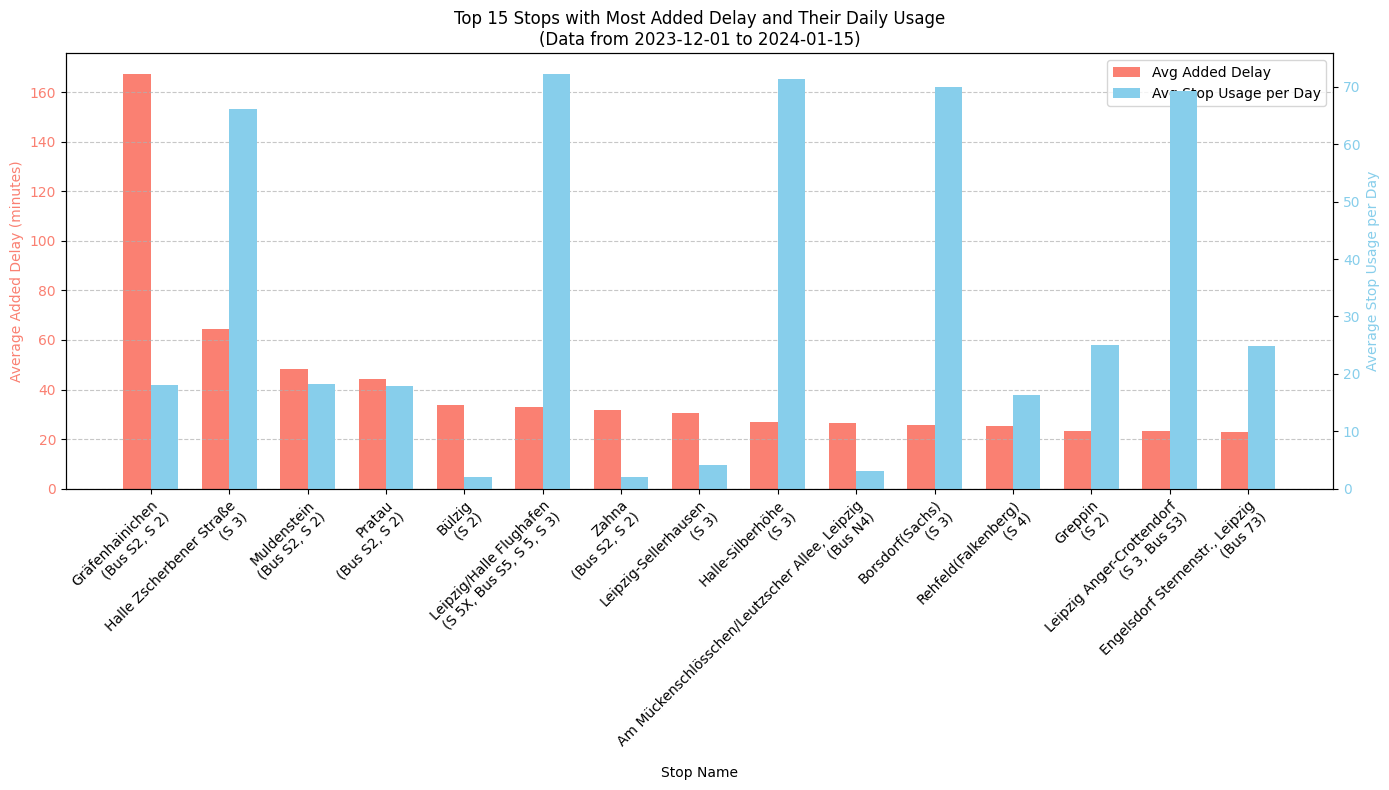

In [64]:
# Calculate top 15 stops with the most added delay
start_time = time.time()

top_delay_stops = df.groupBy('stopId') \
    .agg(avg('added_delay').alias('avg_added_delay')) \
    .orderBy(col('avg_added_delay').desc()) \
    .limit(15) \
    .cache()

top_delay_stops_with_names = top_delay_stops.join(
    broadcast(stops_df),
    top_delay_stops.stopId == stops_df.id,
    "inner"
).select(
    top_delay_stops.stopId,
    "name",
    "avg_added_delay"
).orderBy(col("avg_added_delay").desc()) \
 .cache()

# Join with the original DataFrame to get lineId
top_delay_stops_with_lineId = top_delay_stops_with_names.alias("tdswn").join(
    df.alias("df"),
    col("tdswn.stopId") == col("df.stopId"),
    "left"
).select(
    col("tdswn.stopId"),
    col("tdswn.name"),
    col("tdswn.avg_added_delay"),
    col("df.lineId")
).distinct()

# Join with lines_df to get line names
stops_with_lines = top_delay_stops_with_lineId.alias("tdswl").join(
    lines_df.alias("lines"),
    col("tdswl.lineId") == col("lines.line_id"),
    "left"
).select(
    col("tdswl.stopId"),
    col("tdswl.name"),
    col("tdswl.avg_added_delay"),
    col("lines.name").alias("line_name")
)

# Collect the line names for each stop
stops_with_lines_pd = stops_with_lines.groupBy("stopId", "name", "avg_added_delay").agg(
    F.collect_list("line_name").alias("line_names")
).toPandas()

# Function to format line names
def format_line_names(line_names):
    return f"({', '.join(line_names)})" if line_names else "(No lines)"

# Apply the function to format line names
stops_with_lines_pd["line_names"] = stops_with_lines_pd["line_names"].apply(format_line_names)

# Combine stop names with line names
stops_with_lines_pd["name_with_lines"] = stops_with_lines_pd.apply(
    lambda row: f"{row['name']}\n{row['line_names']}", axis=1
)

# Convert to Pandas for plotting
start_time = time.time()
delay_stops_pd = stops_with_lines_pd
execution_duration = time.time() - start_time
print(f"Converted top 15 to Pandas in {round(execution_duration, 2)} seconds")

# Get date range
date_range = df.agg(
    F.min("plannedWhen").alias("min_date"),
    F.max("plannedWhen").alias("max_date")
).collect()[0]

min_date = date_range["min_date"]
max_date = date_range["max_date"]
days_diff = (max_date - min_date).days + 1  # Add 1 to include both start and end dates

# Get stop usage for the most delayed stops
stop_ids = delay_stops_pd['stopId'].tolist()
stop_usage = df.filter(col('stopId').isin(stop_ids)) \
    .groupBy('stopId') \
    .count() \
    .withColumn('count_per_day', col('count') / days_diff) \
    .orderBy(col('stopId'))

# Convert to Pandas and merge with delay_stops_pd
stop_usage_pd = stop_usage.toPandas()
delay_stops_pd = delay_stops_pd.merge(stop_usage_pd, on='stopId')

# Sort the DataFrame by avg_added_delay in descending order
delay_stops_pd = delay_stops_pd.sort_values(by='avg_added_delay', ascending=False)

# Plotting
fig, ax1 = plt.subplots(figsize=(14, 8))

# Add dashed y-grid
ax1.yaxis.grid(True, linestyle='--', alpha=0.7)

# Plot average added delay on the primary y-axis
bar_width = 0.35
x = range(len(delay_stops_pd['name_with_lines']))
ax1.bar([i - bar_width/2 for i in x], delay_stops_pd['avg_added_delay'], width=bar_width, color='salmon', label='Avg Added Delay')
ax1.set_xlabel('Stop Name')
ax1.set_ylabel('Average Added Delay (seconds)', color='salmon')
ax1.tick_params(axis='y', labelcolor='salmon')
ax1.set_xticks(x)
ax1.set_xticklabels(delay_stops_pd['name_with_lines'])  # Use stop names with line names for x-axis labels

# Create a second y-axis for stop usage per day
ax2 = ax1.twinx()
ax2.bar([i + bar_width/2 for i in x], delay_stops_pd['count_per_day'], width=bar_width, color='skyblue', label='Avg Stop Usage per Day')
ax2.set_ylabel('Average Stop Usage per Day', color='skyblue')
ax2.tick_params(axis='y', labelcolor='skyblue')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title(f'Top 15 Stops with Most Added Delay and Their Daily Usage\n(Data from {min_date.date()} to {max_date.date()})')

# Rotate and align the tick labels so they look better
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Adjust the subplot layout
fig.tight_layout()

# Show the plot
plt.show()

24/09/23 12:40:31 WARN CacheManager: Asked to cache already cached data.
24/09/23 12:40:31 WARN CacheManager: Asked to cache already cached data.


Converted top 15 to Pandas in 0.0 seconds


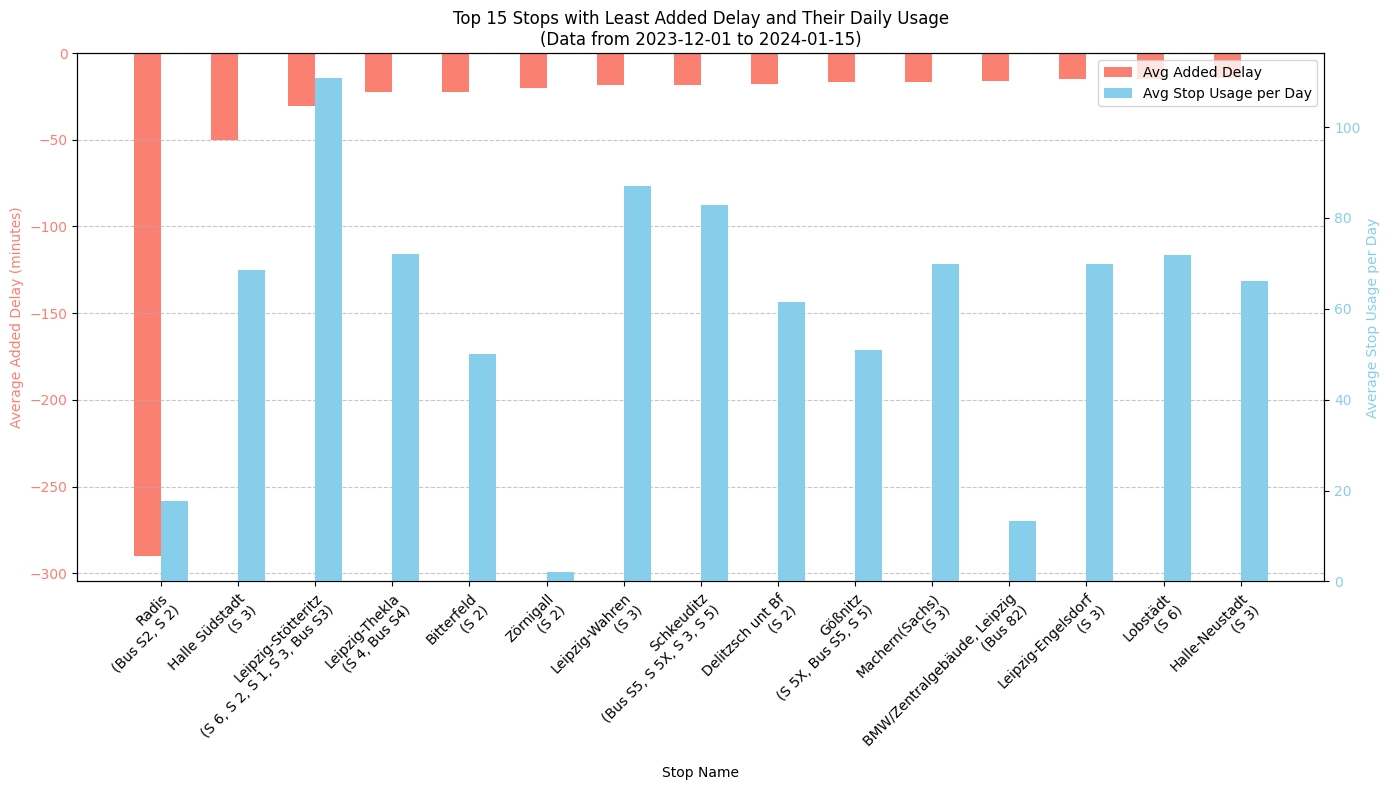

In [66]:
start_time = time.time()

# Calculate top 15 stops with the least added delay
start_time = time.time()

top_delay_stops = df.groupBy('stopId') \
    .agg(avg('added_delay').alias('avg_added_delay')) \
    .orderBy(col('avg_added_delay').asc()) \
    .limit(15) \
    .cache()

top_delay_stops_with_names = top_delay_stops.join(
    broadcast(stops_df),
    top_delay_stops.stopId == stops_df.id,
    "inner"
).select(
    top_delay_stops.stopId,
    "name",
    "avg_added_delay"
).orderBy(col("avg_added_delay").asc()) \
 .cache()

# Join with the original DataFrame to get lineId
top_delay_stops_with_lineId = top_delay_stops_with_names.alias("tdswn").join(
    df.alias("df"),
    col("tdswn.stopId") == col("df.stopId"),
    "left"
).select(
    col("tdswn.stopId"),
    col("tdswn.name"),
    col("tdswn.avg_added_delay"),
    col("df.lineId")
).distinct()

# Join with lines_df to get line names
stops_with_lines = top_delay_stops_with_lineId.alias("tdswl").join(
    lines_df.alias("lines"),
    col("tdswl.lineId") == col("lines.line_id"),
    "left"
).select(
    col("tdswl.stopId"),
    col("tdswl.name"),
    col("tdswl.avg_added_delay"),
    col("lines.name").alias("line_name")
)

# Collect the line names for each stop
stops_with_lines_pd = stops_with_lines.groupBy("stopId", "name", "avg_added_delay").agg(
    F.collect_list("line_name").alias("line_names")
).toPandas()

# Function to format line names
def format_line_names(line_names):
    return f"({', '.join(line_names)})" if line_names else "(No lines)"

# Apply the function to format line names
stops_with_lines_pd["line_names"] = stops_with_lines_pd["line_names"].apply(format_line_names)

# Combine stop names with line names
stops_with_lines_pd["name_with_lines"] = stops_with_lines_pd.apply(
    lambda row: f"{row['name']}\n{row['line_names']}", axis=1
)

# Convert to Pandas for plotting
start_time = time.time()
delay_stops_pd = stops_with_lines_pd
execution_duration = time.time() - start_time
print(f"Converted top 15 to Pandas in {round(execution_duration, 2)} seconds")

# Get date range
date_range = df.agg(
    F.min("plannedWhen").alias("min_date"),
    F.max("plannedWhen").alias("max_date")
).collect()[0]

min_date = date_range["min_date"]
max_date = date_range["max_date"]
days_diff = (max_date - min_date).days + 1  # Add 1 to include both start and end dates

# Get stop usage for the least delayed stops
stop_ids = delay_stops_pd['stopId'].tolist()
stop_usage = df.filter(col('stopId').isin(stop_ids)) \
    .groupBy('stopId') \
    .count() \
    .withColumn('count_per_day', col('count') / days_diff) \
    .orderBy(col('stopId'))

# Convert to Pandas and merge with delay_stops_pd
stop_usage_pd = stop_usage.toPandas()
delay_stops_pd = delay_stops_pd.merge(stop_usage_pd, on='stopId')

# Sort the DataFrame by avg_added_delay in ascending order
delay_stops_pd = delay_stops_pd.sort_values(by='avg_added_delay', ascending=True)

# Plotting
fig, ax1 = plt.subplots(figsize=(14, 8))

# Add dashed y-grid
ax1.yaxis.grid(True, linestyle='--', alpha=0.7)

# Plot average added delay on the primary y-axis
bar_width = 0.35
x = range(len(delay_stops_pd['name_with_lines']))
ax1.bar([i - bar_width/2 for i in x], delay_stops_pd['avg_added_delay'], width=bar_width, color='salmon', label='Avg Added Delay')
ax1.set_xlabel('Stop Name')
ax1.set_ylabel('Average Added Delay (seconds)', color='salmon')
ax1.tick_params(axis='y', labelcolor='salmon')
ax1.set_xticks(x)
ax1.set_xticklabels(delay_stops_pd['name_with_lines'])  # Use stop names with line names for x-axis labels

# Create a second y-axis for stop usage per day
ax2 = ax1.twinx()
ax2.bar([i + bar_width/2 for i in x], delay_stops_pd['count_per_day'], width=bar_width, color='skyblue', label='Avg Stop Usage per Day')
ax2.set_ylabel('Average Stop Usage per Day', color='skyblue')
ax2.tick_params(axis='y', labelcolor='skyblue')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title(f'Top 15 Stops with Least Added Delay and Their Daily Usage\n(Data from {min_date.date()} to {max_date.date()})')

# Rotate and align the tick labels so they look better
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Adjust the subplot layout
fig.tight_layout()

# Show the plot
plt.show()

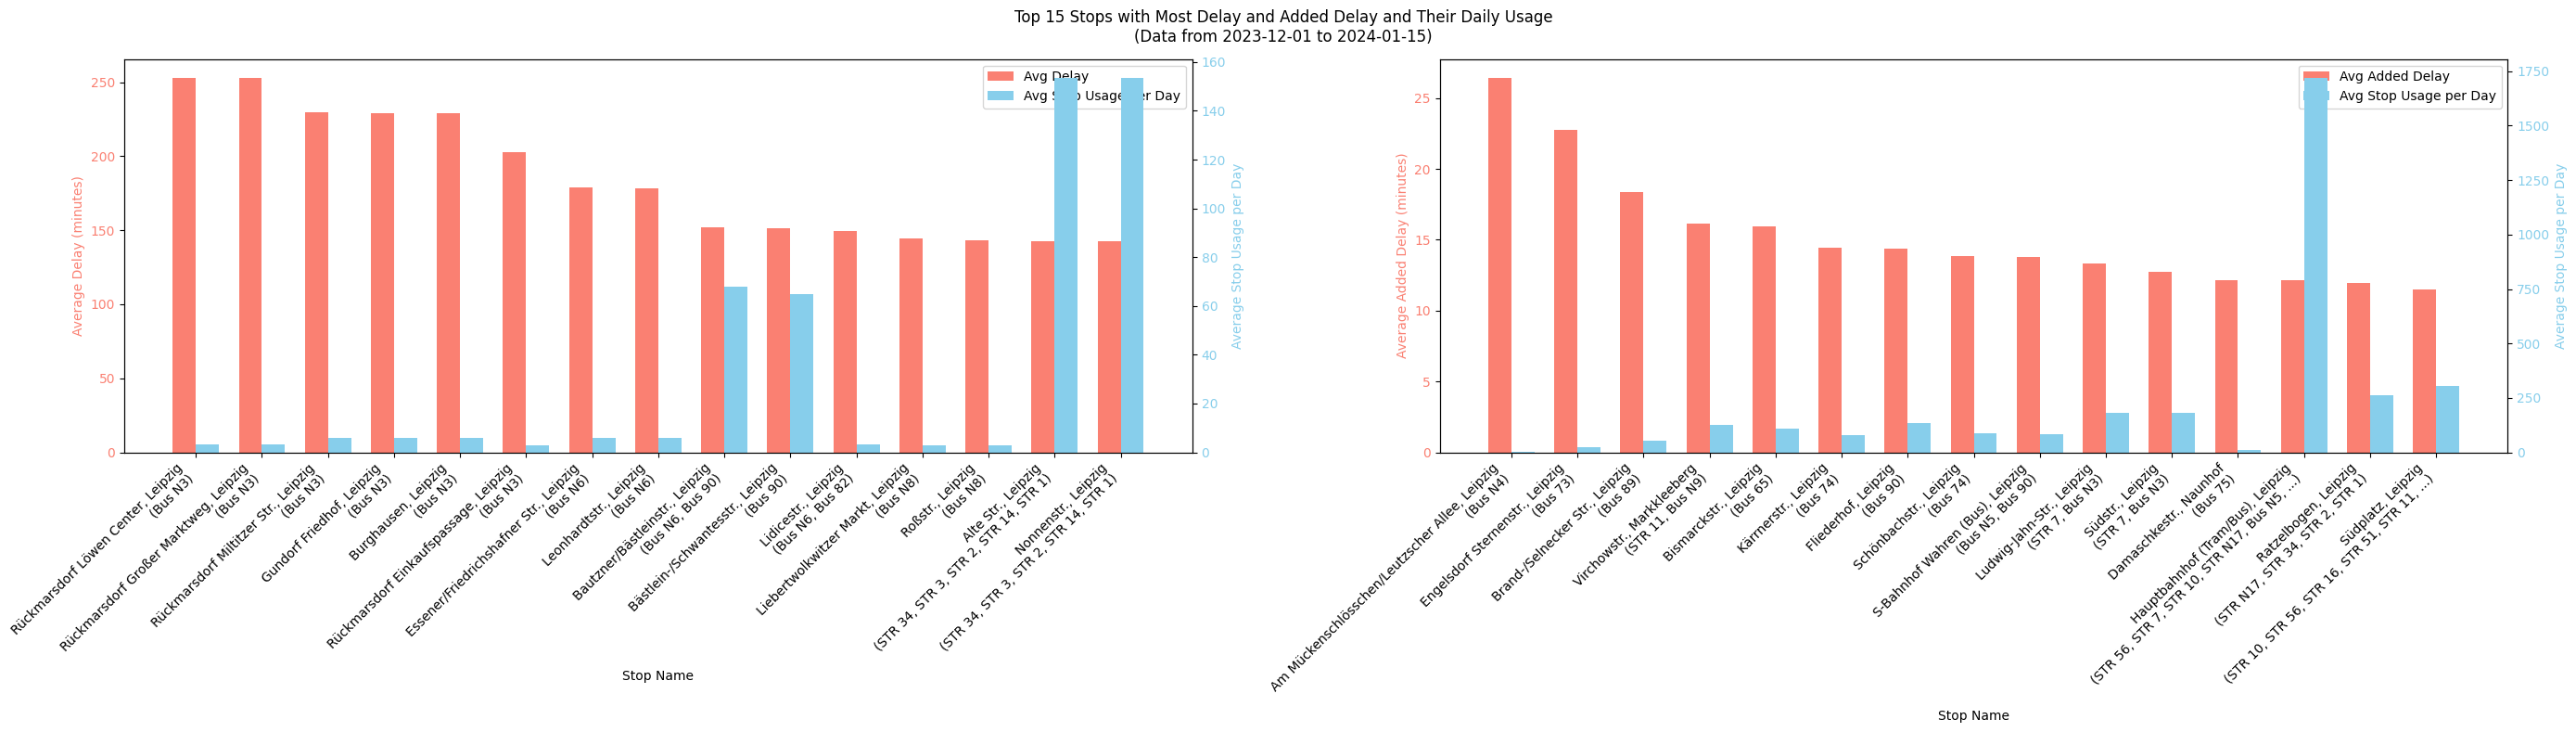

In [71]:
# Load line data
with open("data/relevantLines_with_stops.json", "r") as file:
    json_data = json.load(file)

# Create a list of rows
rows = [(line_id, line_info['name'], line_info['product']) for line_id, line_info in json_data.items()]

# Define the schema for the DataFrame
schema = StructType([
    StructField("line_id", StringType(), True),
    StructField("name", StringType(), True),
    StructField("product", StringType(), True)
])

# Create the DataFrame
lines_df = spark.createDataFrame(rows, schema)

# Join the enriched departures with the line information
joined_df = df.join(lines_df, df.lineId == lines_df.line_id, "left") \
    .select(df["*"], 
            lines_df.name.alias("line_name"), 
            lines_df.product.alias("line_product"))

# Filter out stops with line_product "regional" or "suburban"
filtered_df = joined_df.filter(~col("line_product").isin(["regional", "suburban"]))

# Calculate average delay for all stops
avg_delay_stops = filtered_df.groupBy('stopId') \
    .agg(avg('delay').alias('avg_delay')) \
    .orderBy(col('avg_delay').desc()) \
    .limit(15) \
    .cache()

# Calculate average added delay for all stops
avg_added_delay_stops = filtered_df.groupBy('stopId') \
    .agg(avg('added_delay').alias('avg_added_delay')) \
    .orderBy(col('avg_added_delay').desc()) \
    .limit(15) \
    .cache()

# Join with stop names using broadcast join
top_avg_delay_stops_with_names = avg_delay_stops.join(
    broadcast(stops_df),
    avg_delay_stops.stopId == stops_df.id,
    "inner"
).select(
    avg_delay_stops.stopId,
    "name",
    "avg_delay"
).orderBy(col("avg_delay").desc()) \
 .cache()

top_avg_added_delay_stops_with_names = avg_added_delay_stops.join(
    broadcast(stops_df),
    avg_added_delay_stops.stopId == stops_df.id,
    "inner"
).select(
    avg_added_delay_stops.stopId,
    "name",
    "avg_added_delay"
).orderBy(col("avg_added_delay").desc()) \
 .cache()

# Join with the original DataFrame to get lineId
top_avg_delay_stops_with_lineId = top_avg_delay_stops_with_names.alias("tdswn").join(
    df.alias("df"),
    col("tdswn.stopId") == col("df.stopId"),
    "left"
).select(
    col("tdswn.stopId"),
    col("tdswn.name"),
    col("tdswn.avg_delay"),
    col("df.lineId")
).distinct()

top_avg_added_delay_stops_with_lineId = top_avg_added_delay_stops_with_names.alias("tdswn").join(
    df.alias("df"),
    col("tdswn.stopId") == col("df.stopId"),
    "left"
).select(
    col("tdswn.stopId"),
    col("tdswn.name"),
    col("tdswn.avg_added_delay"),
    col("df.lineId")
).distinct()

# Join with lines_df to get line names
stops_with_lines_delay = top_avg_delay_stops_with_lineId.alias("tdswl").join(
    lines_df.alias("lines"),
    col("tdswl.lineId") == col("lines.line_id"),
    "left"
).select(
    col("tdswl.stopId"),
    col("tdswl.name"),
    col("tdswl.avg_delay"),
    col("lines.name").alias("line_name")
)

stops_with_lines_added_delay = top_avg_added_delay_stops_with_lineId.alias("tdswl").join(
    lines_df.alias("lines"),
    col("tdswl.lineId") == col("lines.line_id"),
    "left"
).select(
    col("tdswl.stopId"),
    col("tdswl.name"),
    col("tdswl.avg_added_delay"),
    col("lines.name").alias("line_name")
)

# Collect the line names for each stop
stops_with_lines_delay_pd = stops_with_lines_delay.groupBy("stopId", "name", "avg_delay").agg(
    F.collect_list("line_name").alias("line_names")
).toPandas()

stops_with_lines_added_delay_pd = stops_with_lines_added_delay.groupBy("stopId", "name", "avg_added_delay").agg(
    F.collect_list("line_name").alias("line_names")
).toPandas()

# Function to format line names
def format_line_names(line_names):
    if len(line_names) > 5:
        line_names = line_names[:5] + ["..."]
    return f"({', '.join(line_names)})" if line_names else "(No lines)"

# Apply the function to format line names
stops_with_lines_delay_pd["line_names"] = stops_with_lines_delay_pd["line_names"].apply(format_line_names)
stops_with_lines_added_delay_pd["line_names"] = stops_with_lines_added_delay_pd["line_names"].apply(format_line_names)

# Combine stop names with line names
stops_with_lines_delay_pd["name_with_lines"] = stops_with_lines_delay_pd.apply(
    lambda row: f"{row['name']}\n{row['line_names']}", axis=1
)

stops_with_lines_added_delay_pd["name_with_lines"] = stops_with_lines_added_delay_pd.apply(
    lambda row: f"{row['name']}\n{row['line_names']}", axis=1
)

# Convert to Pandas for plotting
avg_delay_stops_pd = stops_with_lines_delay_pd.sort_values(by='avg_delay', ascending=False)
avg_added_delay_stops_pd = stops_with_lines_added_delay_pd.sort_values(by='avg_added_delay', ascending=False)

# Get date range
date_range = df.agg(
    F.min("plannedWhen").alias("min_date"),
    F.max("plannedWhen").alias("max_date")
).collect()[0]

min_date = date_range["min_date"]
max_date = date_range["max_date"]
days_diff = (max_date - min_date).days + 1  # Add 1 to include both start and end dates

# Get stop usage for the most delayed stops
stop_ids = avg_delay_stops_pd['stopId'].tolist() + avg_added_delay_stops_pd['stopId'].tolist()
stop_usage = df.filter(col('stopId').isin(stop_ids)) \
    .groupBy('stopId') \
    .count() \
    .withColumn('count_per_day', col('count') / days_diff) \
    .orderBy(col('stopId'))

# Convert to Pandas and merge with delay_stops_pd
stop_usage_pd = stop_usage.toPandas()
avg_delay_stops_pd = avg_delay_stops_pd.merge(stop_usage_pd, on='stopId')
avg_added_delay_stops_pd = avg_added_delay_stops_pd.merge(stop_usage_pd, on='stopId')

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 8))

# Plot average delay on the primary y-axis
bar_width = 0.35
x1 = range(len(avg_delay_stops_pd['name_with_lines']))
ax1.bar([i - bar_width/2 for i in x1], avg_delay_stops_pd['avg_delay'], width=bar_width, color='salmon', label='Avg Delay')
ax1.set_xlabel('Stop Name')
ax1.set_ylabel('Average Delay (seconds)', color='salmon')
ax1.tick_params(axis='y', labelcolor='salmon')
ax1.set_xticks(x1)
ax1.set_xticklabels(avg_delay_stops_pd['name_with_lines'], rotation=45, ha='right')

# Create a second y-axis for stop usage per day
ax1_2 = ax1.twinx()
ax1_2.bar([i + bar_width/2 for i in x1], avg_delay_stops_pd['count_per_day'], width=bar_width, color='skyblue', label='Avg Stop Usage per Day')
ax1_2.set_ylabel('Average Stop Usage per Day', color='skyblue')
ax1_2.tick_params(axis='y', labelcolor='skyblue')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Plot average added delay on the primary y-axis
bar_width = 0.35
x2 = range(len(avg_added_delay_stops_pd['name_with_lines']))
ax2.bar([i - bar_width/2 for i in x2], avg_added_delay_stops_pd['avg_added_delay'], width=bar_width, color='salmon', label='Avg Added Delay')
ax2.set_xlabel('Stop Name')
ax2.set_ylabel('Average Added Delay (seconds)', color='salmon')
ax2.tick_params(axis='y', labelcolor='salmon')
ax2.set_xticks(x2)
ax2.set_xticklabels(avg_added_delay_stops_pd['name_with_lines'], rotation=45, ha='right')

# Create a second y-axis for stop usage per day
ax2_2 = ax2.twinx()
ax2_2.bar([i + bar_width/2 for i in x2], avg_added_delay_stops_pd['count_per_day'], width=bar_width, color='skyblue', label='Avg Stop Usage per Day')
ax2_2.set_ylabel('Average Stop Usage per Day', color='skyblue')
ax2_2.tick_params(axis='y', labelcolor='skyblue')

# Add legend
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.suptitle(f'Top 15 Stops with Most Delay and Added Delay and Their Daily Usage\n(Data from {min_date.date()} to {max_date.date()})')

# Adjust the subplot layout
fig.tight_layout()

# Show the plot
plt.show()